# Fine-tuning for classification
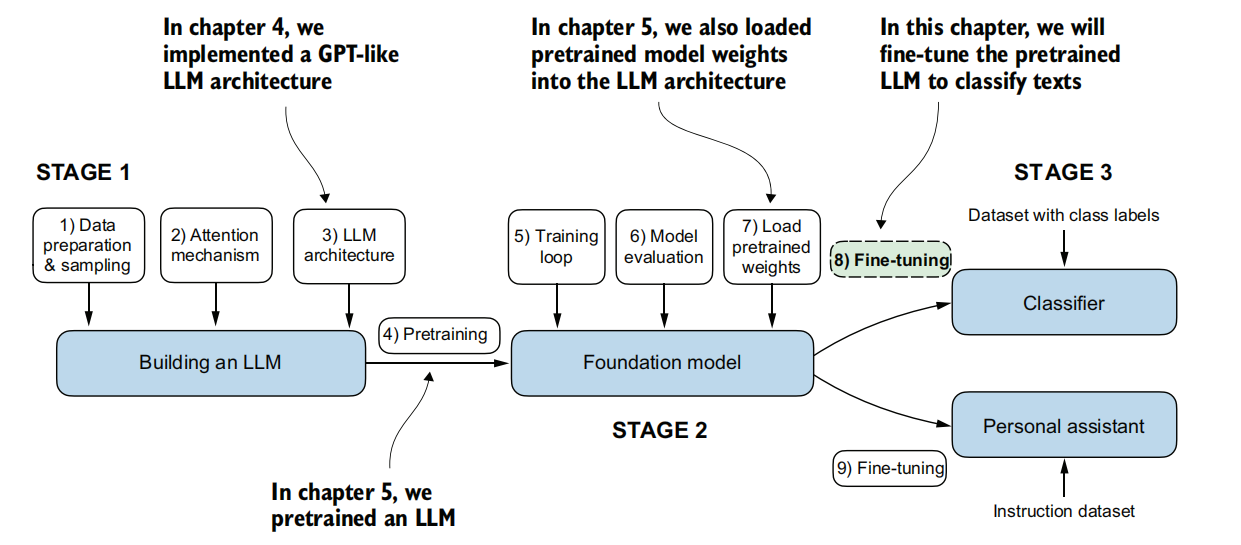

## 1. Instruction Fine-Tuning
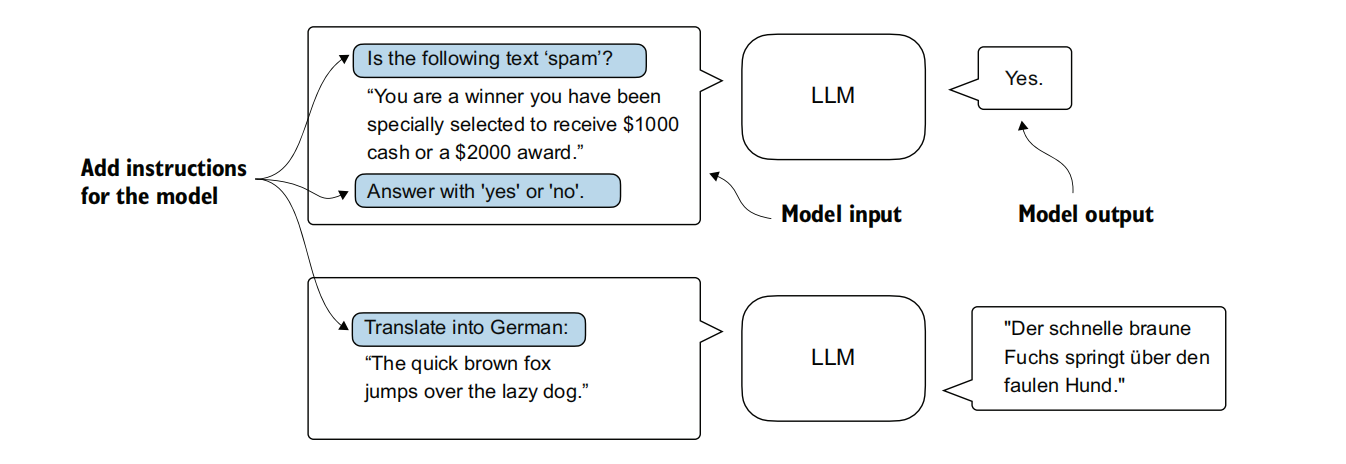

## 2. Classification Fine-Tuning
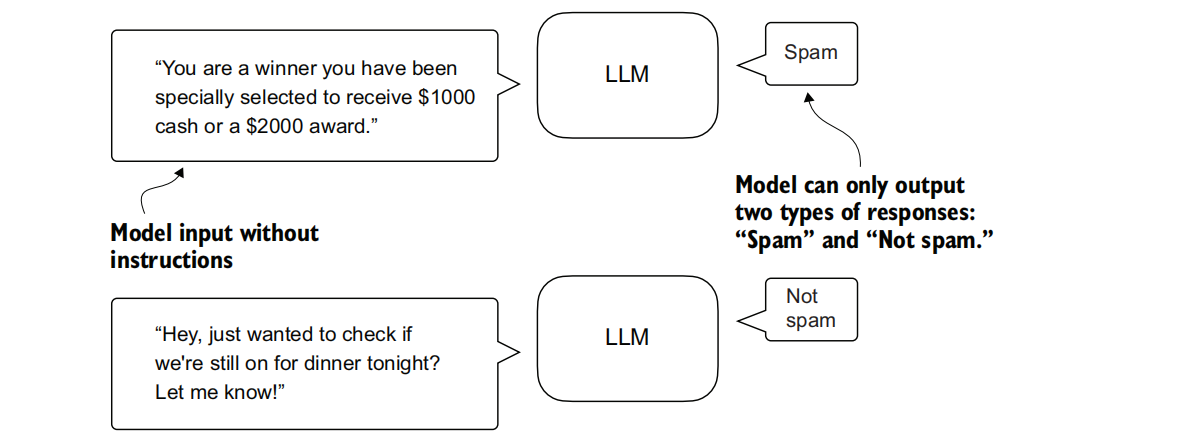

## Preparing the dataset

In [1]:
import urllib.request
import zipfile
import os
from pathlib import Path

In [2]:
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download ""and extraction.")
        return
    with urllib.request.urlopen(url) as response: 
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())
    with zipfile.ZipFile(zip_path, "r") as zip_ref: 
        zip_ref.extractall(extracted_path)
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path) 
    print(f"File downloaded and saved as {data_file_path}")
download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

File downloaded and saved as sms_spam_collection\SMSSpamCollection.tsv


In [3]:
import pandas as pd
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

c:\Users\AKSHAT SHAW\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [4]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


#### Creating a Balanced data-set

In [5]:
def create_balanced_dataset(df):
    num_spam = df[df["Label"] == "spam"].shape[0] 
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123) 
    balanced_df = pd.concat([
        ham_subset, df[df["Label"] == "spam"]
    ]) 
    return balanced_df
balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [6]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

In [7]:
def random_split(df, train_frac, validation_frac):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True) 
    
    train_end = int(len(df) * train_frac) 
    validation_end = train_end + int(len(df) * validation_frac)
    
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]
    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

In [8]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

## Creating the DataLoaders

We now have 2 options for the data:
1. Truncate all messages to the length of the shortest message in the dataset or batch.
2. Pad all messages to the length of the longest message in the dataset or batch.

The first option is computationally cheaper, but it may result in significant information loss if shorter messages are much smaller than the average or longest messages,potentially reducing model performance.

So we will go on with the 2nd option.

- To implement batching, where all messages are padded to the length of the longest message in the dataset, we add padding tokens to all shorter messages. For this
purpose, we use "<|endoftext|>" as a padding token.

In [9]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


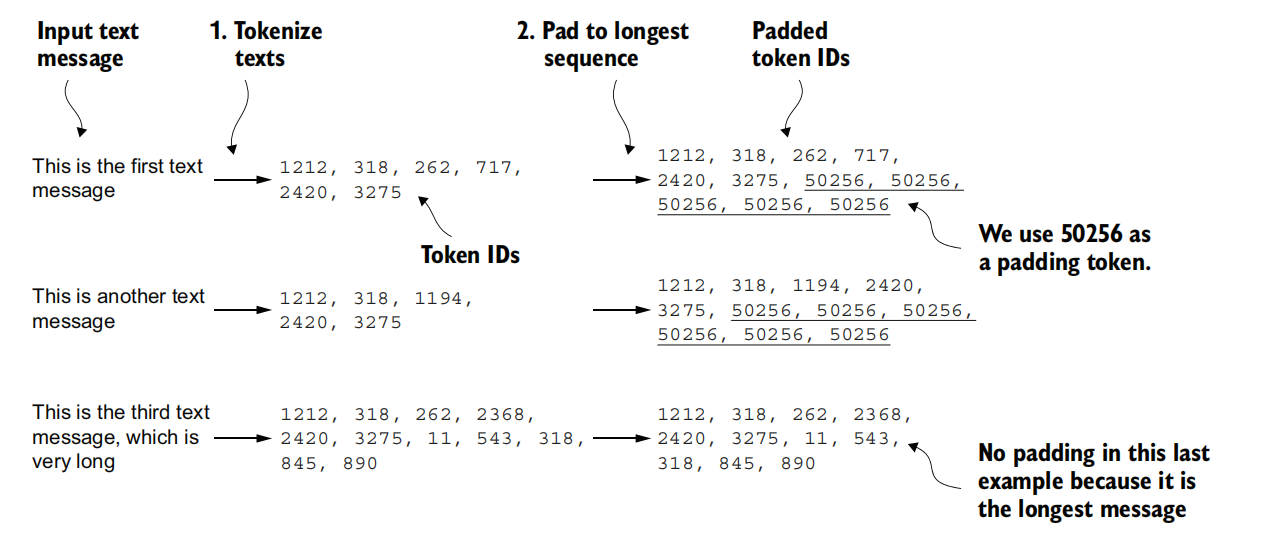

In [10]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)
        self.encoded_texts = [tokenizer.encode(text) for text in self.data["Text"]]
        
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
        
        self.encoded_texts = [
            encoded_text[:self.max_length] for encoded_text in self.encoded_texts
        ]
        
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]
    
    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )
    
    def __len__(self):
        return len(self.data)
    
    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length


In [11]:
train_dataset = SpamDataset(
 csv_file="train.csv",
 max_length=None,
 tokenizer=tokenizer
)

In [12]:
print(train_dataset.max_length)

120


In [13]:
val_dataset = SpamDataset(
 csv_file="validation.csv",
 max_length=train_dataset.max_length,
 tokenizer=tokenizer
)
test_dataset = SpamDataset(
 csv_file="test.csv",
 max_length=train_dataset.max_length,
 tokenizer=tokenizer
)

In [16]:
from torch.utils.data import DataLoader

num_workers = 0 
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [18]:
for input_batch, target_batch in train_loader:
    print("Input batch dimensions:", input_batch.shape)
    print("Label batch dimensions", target_batch.shape)
    break

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [19]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches
